In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import os 
from scipy.stats import norm 
from scipy.ndimage.interpolation import shift 
from collections import deque
from scipy.stats import shapiro, kstest
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_rows = 100 

C:\Users\bmw_7\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [22]:
prices_dollar = yf.download('USD', '2015-10-01','2020-10-01')
prices_moex = yf.download('MOEX.ME', '2015-10-01','2020-10-01')
prices_gold = yf.download('GOLD', '2015-10-01','2020-10-01')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [31]:
prices_dollar['Close'][100]

11.186666488647461

In [15]:
def one_ticker_data(path, sep=',', skiprows=1):
    df = pd.read_csv(path, sep=sep, skiprows=skiprows, 
                     names=['Ticker', 'Per', 'Date', 'Time', 'Open', 'High', 'Low', 'Close', 'Vol'])
    df = pd.DataFrame(df[['Ticker', 'Date', 'Close']])
    df = df.sort_values(by=['Ticker', 'Date'], ascending=True)
    
    return df

In [5]:
class DataCounter:
    
    
    def __init__(self, data): 
        self._data = data
        
        ##self.ticker = self._data['Ticker'].unique()[0]
        self.date = np.array(self._data.index.values)
        self.price = np.array(self._data['Close'])
        
        self.returns = None
        self.logreturns = None
        self.risk_returns = None 
        self.risk_logreturns = None 
        
        self.historical_var = None 
        self.historical_ear = None 
        self.historical_rorac = None 
        
        self.var = None 
        self.ear = None 
        self.rorac = None 
        
        self.__manip = 1
        self.__manvar = 1 
        self.__manear = 1 
        self.__manrorac = 1 
        
        self.__var = 1 
        self.__ear = 1 
        self.__rorac = 1
        
        
    def solve_returns(self): 
        self.returns = np.array([np.nan] + list((self.price[1:] - shift(self.price, 1)[1:]) / shift(self.price, 1)[1:]))
        self.logreturns = np.array([np.nan] + list(np.log(self.price[1:] / shift(self.price, 1)[1:])))
        self.risk_returns = - self.returns 
        self.risk_logreturns = -self.logreturns
        self.__manip = 0
    
    
    def var_hist(self, window=252, perc=.01): 
        if self.__manip: 
            self.solve_returns()
        self.historical_var = [np.nan] * len(self.returns)
        
        if self.__manvar:
            calc_deque = deque(maxlen=window)
            for j in range(len(self.risk_returns)): 
                if self.risk_returns[j] != np.nan: 
                    calc_deque.append(self.risk_returns[j])
                else:
                    continue
                if len(calc_deque) == window: 
                    self.historical_var[j] = -min(pd.Series(calc_deque).quantile(perc), 0)
            self.__manvar = 0
        
        return self.historical_var
    
    
    def ear_hist(self, window=252, perc=0.5): 
        if self.__manip:
            self.solve_returns()
        self.historical_ear = [np.nan] * len(self.logreturns)
        
        if self.__manear:
            calc_deque = deque(maxlen=window)
            for j in range(len(self.logreturns)):
                if self.logreturns[j] != np.nan: 
                    calc_deque.append(self.logreturns[j])
                else:
                    continue
                if len(calc_deque) == window:
                    self.historical_ear[j] = -pd.Series(calc_deque).quantile(perc)
            self.__manear = 0
        
        return self.historical_ear
    
    
    def rorac_hist(self, window=252):
        if self.__manip:
            self.solve_returns()
        if self.__manvar:
            self.var_hist()
        if self.__manear: 
            self.ear_hist()
        if self.__manrorac: 
            self.historical_rorac = (self.logreturns - self.historical_ear) / self.historical_var
            self.__manrorac = 0
        
        return self.historical_rorac
    
    
    def var_param(self, window=252, perc=0.01):
        if self.__manip:
            self.solve_returns()
        self.var = [np.nan] * len(self.logreturns)
        
        if self.__var:
            calc_deque = deque(maxlen=window)
            for j in range(len(self.logreturns)):
                if self.logreturns[j] != np.nan: 
                    calc_deque.append(self.logreturns[j])
                else:
                    continue
                if len(calc_deque) == window: 
                    self.var[j] = -min(norm.ppf(perc, np.mean(pd.Series(calc_deque)), np.std(pd.Series(calc_deque))), 0)
            self.__var = 0
        self.var = np.array(self.var)
        
        return self.var
    
    
    def ear_param(self, window=252, perc=0.5):
        if self.__manip: 
            self.solve_returns()
        self.ear = [np.nan] * len(self.logreturns)
        
        if self.__ear: 
            calc_deque = deque(maxlen=window)
            for j in range(len(self.logreturns)):
                if self.logreturns[j] != np.nan: 
                    calc_deque.append(self.logreturns[j])
                else: 
                    continue
                if len(calc_deque) == window: 
                    self.ear[j] = -norm.ppf(perc, np.mean(pd.Series(calc_deque)), np.std(pd.Series(calc_deque)))
            self.__var = 0
        self.ear = np.array(self.ear)
        
        return self.ear
    
    
    def rorac_param(self):
        if self.__manip:
            self.solve_returns()
        if self.__var:
            self.var_param()
        if self.__ear:
            self.ear_param()
        self.rorac = (self.logreturns - self.ear) / self.var
        self.rorac = np.array(self.rorac)
        
        return self.rorac

    
    def solve(self): 
        if self.__manip:
            self.solve_returns()
        if self.__manvar:
            self.var_hist()
        if self.__manear:
            self.ear_hist()
        if self.__manrorac:
            self.rorac_hist()
        
        if self.__var:
            self.var_param()
        if self.__ear:
            self.ear_param()
        if self.__rorac:
            self.rorac_param()
            
        array = [self.date, self.historical_var, self.historical_ear, self.historical_rorac,\
                 self.var, self.ear, self.rorac]
        
        self.result = pd.DataFrame(array).transpose()
        self.result.columns = ['Date', 'Hist VaR', 'Hist EaR', 'Hist RORAC', 'Param VaR',
                               'Param EaR', 'Param RORAC']
        self.result = self.result.dropna()
        
        return self.result
    
    
    def plot(self):
        plt.figure()
        plt.subplot(2, 1, 1)
        plt.plot(list(range(0, len(self.date))), list(map(lambda x: 100*x, self.historical_var)))
        plt.plot(list(range(0, len(self.date))), list(map(lambda x: 100*x, self.historical_ear)))
        plt.xlabel('time (day count)')
        plt.ylabel('%')
        plt.title('Historical VaR & EaR, RORAC')
        plt.subplot(2, 1, 2)
        plt.plot(list(range(0, len(self.date))), list(map(lambda x: 100*x, self.historical_rorac)))
        plt.xlabel('time (day count)')
        plt.ylabel('%')
        plt.show()
    
    
    def normality(self):
        stat, p = shapiro(self.risk_logreturns[1:])
        
        stat2, p2 = kstest(count.logreturns[1:], 'norm').statistic, \
                    kstest(count.logreturns[1:], 'norm').pvalue
        
        return 'Statistics Shapiro={:.3f}, p={:.3f}'.format(stat, p) + ' & ' + 'Statistics KS-test={:.3f}, p={:.3f}'.format(stat2, p2)

## Результаты расчетов для доллара

In [6]:
count = DataCounter(prices_dollar)
count.solve()

,Date,Hist VaR,Hist EaR,Hist RORAC,Param VaR,Param EaR,Param RORAC
251,2016-09-28,0.0620963,-0.00402364,0.189406,0.0636406,-0.00213517,0.155136
252,2016-09-29,0.0620934,-0.00404925,0.363896,0.0634887,-0.00220029,0.326776
253,2016-09-30,0.0620934,-0.00413496,0.587018,0.0631565,-0.00246349,0.55067
254,2016-10-03,0.0620934,-0.00404925,-0.268828,0.0633489,-0.00229128,-0.291251
255,2016-10-04,0.061105,-0.00395094,-0.0446557,0.0629821,-0.00200341,-0.0742467
...,...,...,...,...,...,...,...
1255,2020-09-24,0.192197,-0.00404994,0.118471,0.135313,-0.00155746,0.149855
1256,2020-09-25,0.192197,-0.00434915,0.226752,0.135255,-0.00172431,0.302808
1257,2020-09-28,0.192197,-0.00450365,0.282781,0.134921,-0.00208816,0.384922
1258,2020-09-29,0.192197,-0.00450365,0.0691032,0.134941,-0.00205362,0.0802678


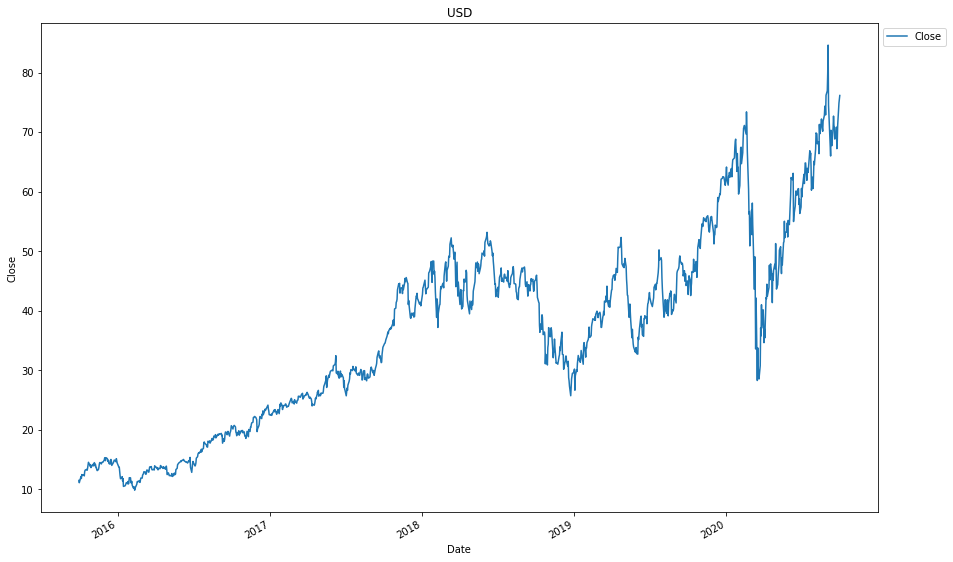

In [15]:
prices_dollar["Close"].plot(figsize=(15,10))
plt.xlabel('Date')
plt.ylabel('Close')
plt.title('USD')
plt.legend(bbox_to_anchor=(1, 1))

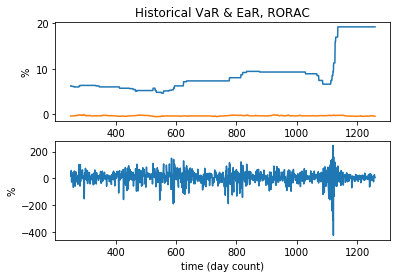

In [17]:
count.plot()

## Тест на нормальность (Shapiro-Wilk Test & Kolmogorov-Smirnov Test)

In [19]:
count.normality()

'Statistics Shapiro=0.888, p=0.000 & Statistics KS-test=0.456, p=0.000'

Логдоходности не могут быть признаны нормальными, а значит, параметрический вариант оценивания не подходит

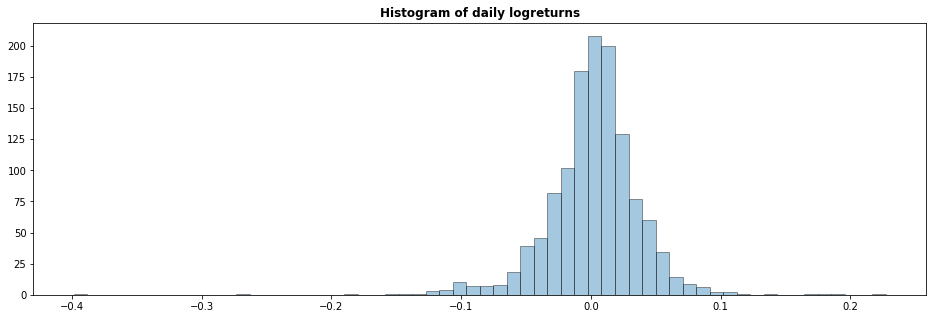

In [24]:
fig = plt.figure(figsize=(16, 5))

sns.distplot(count.logreturns, hist=True, kde=False, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.title("Histogram of daily logreturns", weight="bold")

plt.show()

## Результаты расчетов для MOEX

In [7]:
count2 = DataCounter(prices_moex)
count2.solve()

,Date,Hist VaR,Hist EaR,Hist RORAC,Param VaR,Param EaR,Param RORAC
251,2016-10-03,0.0425601,-0.000545736,0.210574,0.0412791,-0.0019048,0.250032
252,2016-10-04,0.0425493,-0.000464553,-1.40607,0.0423897,-0.00165798,-1.38321
253,2016-10-05,0.0425493,-0.000590416,0.478514,0.0421992,-0.00181492,0.511501
254,2016-10-06,0.0425493,-0.000464553,-0.0562719,0.0422321,-0.00174318,-0.0264183
255,2016-10-07,0.0425493,-0.000362586,-0.103247,0.0421422,-0.00159012,-0.0751163
...,...,...,...,...,...,...,...
1250,2020-09-24,0.0447473,-0.000601745,0.0582952,0.0411482,-0.00164426,0.0887296
1251,2020-09-25,0.0447473,-0.000601745,0.0874843,0.0411541,-0.00163505,0.120231
1252,2020-09-28,0.0447473,-0.00084147,0.304915,0.041059,-0.0017261,0.353851
1253,2020-09-29,0.0447473,-0.00107417,0.252392,0.0410268,-0.00177334,0.292321


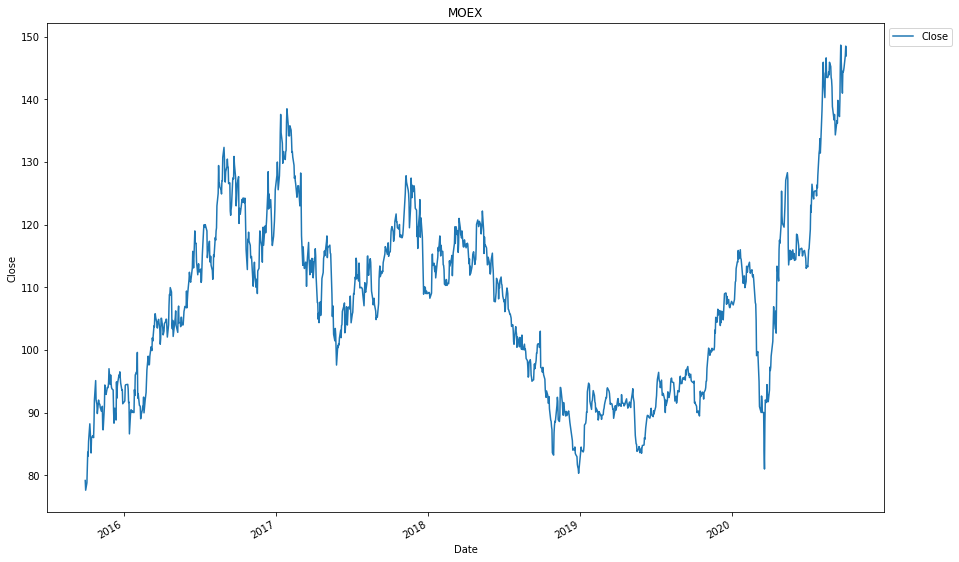

In [27]:
prices_moex['Close'].plot(figsize=(15,10))
plt.xlabel('Date')
plt.ylabel('Close')
plt.title('MOEX')
plt.legend(bbox_to_anchor=(1, 1))

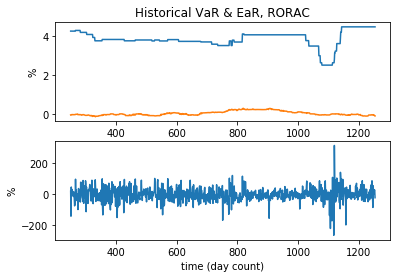

In [28]:
count2.plot()

## Тест на нормальность (Shapiro-Wilk Test & Kolmogorov-Smirnov Test)

In [29]:
count2.normality()

'Statistics Shapiro=0.973, p=0.000 & Statistics KS-test=0.456, p=0.000'

Логдоходности не могут быть признаны нормальными, а значит, параметрический вариант оценивания не подходит

## Результаты расчетов для доллара

In [8]:
count3 = DataCounter(prices_gold)
count3.solve()

,Date,Hist VaR,Hist EaR,Hist RORAC,Param VaR,Param EaR,Param RORAC
251,2016-09-28,0.0992649,-0.00664457,0.304518,0.0800867,-0.00414922,0.346282
252,2016-09-29,0.0992099,-0.00634014,0.0190581,0.079963,-0.0041151,-0.00418061
253,2016-09-30,0.0992099,-0.00634014,-0.0604661,0.0798144,-0.00417365,-0.102304
254,2016-10-03,0.0992099,-0.00558855,-0.133153,0.0797967,-0.00386262,-0.187176
255,2016-10-04,0.0992099,-0.00441093,-1.14782,0.0821324,-0.00322762,-1.40089
...,...,...,...,...,...,...,...
1255,2020-09-24,0.093515,-0.00121046,0.212025,0.0672074,-0.0016639,0.301767
1256,2020-09-25,0.093515,-0.00136555,0.0339227,0.0671769,-0.00168857,0.0520312
1257,2020-09-28,0.093515,-0.00155682,0.0397853,0.0670082,-0.00177912,0.0588409
1258,2020-09-29,0.093515,-0.00169085,0.216538,0.0667925,-0.00194332,0.306951


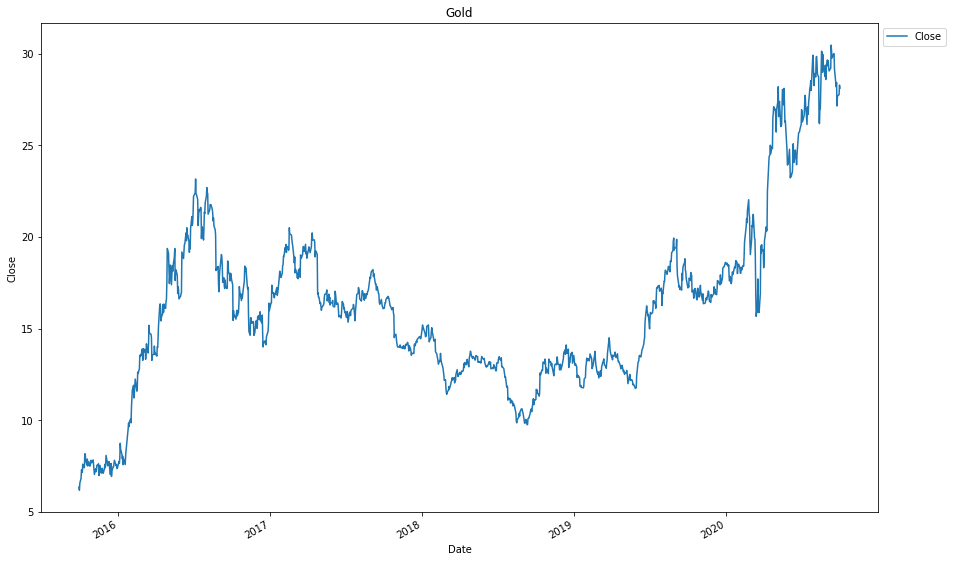

In [32]:
prices_gold["Close"].plot(figsize=(15,10))
plt.xlabel('Date')
plt.ylabel('Close')
plt.title('Gold')
plt.legend(bbox_to_anchor=(1, 1))

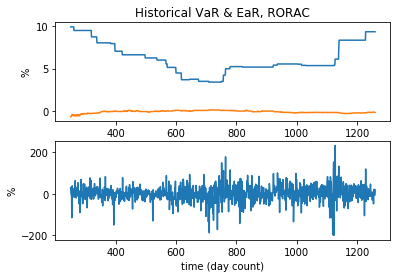

In [38]:
count3.plot()

## Тест на нормальность (Shapiro-Wilk Test & Kolmogorov-Smirnov Test)

In [40]:
count3.normality()

'Statistics Shapiro=0.953, p=0.000 & Statistics KS-test=0.460, p=0.000'

Логдоходности не могут быть признаны нормальными, а значит, параметрический вариант оценивания не подходит

## Выводы

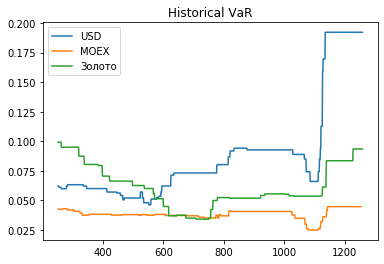

In [25]:
plt.figure()
plt.plot(list(range(len(count.date))), count.historical_var)
plt.plot(list(range(len(count2.date))), count2.historical_var)
plt.plot(list(range(len(count.date))), count3.historical_var)
plt.legend(['USD', 'MOEX', 'Золото'])
plt.title('Historical VaR')
plt.show()

На графике исторического VaR наблюдаются общие паттерны в 2020 году.
Даже динамика золота показывает значительный уровень роста VaR, что не характерно для обычных финансовых кризисов.
Наименьшую чувствутельность показывает динамика MOEX. Наиболее чувстительным оказался курс доллара к рублю, что скорее всего связано с денежной политикой России в ходе экономического кризиса.

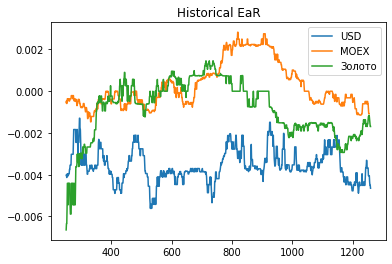

In [28]:
plt.figure()
plt.plot(list(range(len(count.date))), count.historical_ear)
plt.plot(list(range(len(count2.date))), count2.historical_ear)
plt.plot(list(range(len(count.date))), count3.historical_ear)
plt.legend(['USD', 'MOEX', 'Золото'])
plt.title('Historical EaR')
plt.show()

Динамика EaR не показывает нам явных общих паттернов. Для доллара график колеблется на одном уровне, что возможно
определяется, что скорее всего определяется регулированием со стороны Банка России. На графике EaR золота в первой четверти
заметен значительный рост, затем постепенное снижение или удержание на одном уровне - в 2015 году происходили значительные
колебания курса золота на мировых рынках.
Риск процентной ставки в случае MOEX сначала растет, затем снижается.